In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import datetime

# Kalman Filtering

We describe and implement a Kalman filter to make a lake water level time series from satellite altimetry data.

Work on one time step and then put a loop over time steps. We take hints from DAHITI, since they solve the lake water level problem using Kalman filtering. (The KalmanNet paper equations are written differently than the DAHITI paper, but are equivalent.)

### Model:
#### State variable (i.e. lake water levels)

$\mathbf{x}_{t|t-1} = \mathbf{F} \mathbf{x}_{t-1|t-1}$

- $\mathbf{x}$ is the state variable, but essentially represents the lake water level. It is a scalar (just a number)
- $\mathbf{x}_{t|t-1}$ is the prior at time $t$ and $\mathbf{x}_{t|t}$ is the posterior. It is a scalar (just a number). In code, the prior is `x_t_prior` and the posterior is `x_t`
- $\mathbf{F}$ is identity matrix (see equation (4) in DAHITI). Since everything in this equation is a scalar, $\mathbf{F}$ is just a single 1.

$\mathbf{\Sigma}_{t|t-1} = \mathbf{F} \mathbf{\Sigma}_{t-1|t-1} \mathbf{F}^T + \mathbf{Q}$

- $\mathbf{\Sigma}_{t|t-1}$ is the a priori estimate for the error in the state variable at time $t$, and $\mathbf{\Sigma}_{t|t}$ is the posterior. It is a scalar. In code, these are `sigma_t_prior` and `sigma_t`
- $\mathbf{Q}$ is the covariance matrix for the model noise. In this case, it is a scalar.

#### "Observations"
Note that $\mathbf{y}_t$ are the actual lake water observations at time $t$, but $\mathbf{y}_{t|t-1}$ are not; the latter are the prior estimates for the lake water level at time $t$.

$\mathbf{y}_{t|t-1} = \mathbf{H} \mathbf{x}_{t|t-1}$

- $\mathbf{y}_{t|t-1}$ is the prior estimate for all the lake water level measurements at time $t$.
- $\mathbf{H}$ is a column vector of 1's. There are as many ones are there are data points at time $t$. In code, we call this the model matrix because it "models" the state variable into a "guess" for the observations.

$\mathbf{S}_{t|t-1} = \mathbf{H} \mathbf{\Sigma}_{t|t-1} \mathbf{H}^T + \mathbf{R}$
- $\mathbf{S}_{t|t-1}$ is the prior estimate for the error in the observations. Its dimension is $m_t \times m_t$ where $m_t$ is the number of data points at time $t$.
- $\mathbf{R}$ is the covariance matrix for the observation noise. To get it, you take the ADM error for each data point (at the time step) and place the errors along the diagonal. (See equation (3) in the DAHITI paper. Their $\Sigma_{ll,k}$ is our $\mathbf{R}$.) $\mathbf{R}$ is $m_t \times m_t$

#### Kalman Gain
The Kalman Gain is calculated as

$\mathbf{K_t} = \mathbf{\Sigma}_{t|t-1} \mathbf{H}^T \mathbf{S}_{t|t-1}^{-1}$

In code this is `K_t`.

### Process
1. Initialize the Kalman Filter on the first time step. Start by setting the prior estimate for the state variable to the lake water level on the first day with the lowest error. Set the prior estimate for the model noise to 1. Then input the data for the first time point, and define the model matrix, the covariance matrix for the observations, the prior estimate for the error in the observations, and the prior estimates for the lake levels. We also input the observations at the time step (See `y_t` in input_new_data()).

2. Update the Kalman filter. Calculate the Kalman gain and get the posterior state variable estimate `x_t`, which is our lake water estimates, and the posterior estimate for the error in the measurements `sigma_t`.

3. Predict the next priors. Set the posterior of the current time step to the prior of the next time step.

### Other notes
An open question is how should ADM be calculated. Above, in code, (see the `apply` statement in cell 15) we've added a bulk error to the ADM. What should this number be?

How should we esimate $\mathbf{Q}_t$? Can we take hints from the DAHITI paper?

In [2]:
class KalmanFilter:
    def __init__(self):
        self.m_t = 0 # number of points in this time step
        self.x_t_prior = 0 # x_t prior, scalar
        self.x_t = 0 # x_t update, scalar
        self.F_t = 0 # transition matrix, scalar
        self.H_t = 0 # model matrix (m_t, 1)
        self.sigma_t_prior = 0 # model noise, prior; scalar
        self.S_t_prior = 0 # observation noise, prior; (m_t, m_t)
        self.sigma_t = 0 # model noise, update; scalar
        self.S_t = 0 # observation noise, update; (m_t, m_t)
        self.y_t_prior = 0 # predictions for observations based on x_t_prior
        self.y_t = 0 # observations; (m_t, 1)
        self.K_t = 0 # Kalman gain
        self.R_t = 0 # Covariance of noise in the observations at time t
        self.Q_t = 0 # Covariance of the model noise
        
    def initialize(self, lake_data_0):
        # lake_data_0 is the lake data for the zeroth time step.
        # In our Lake Winnipeg case, it will be something like this;
        # lake_data_0 = lake_winnipeg.loc[
        #    lake_winnipeg["date"] = pd.unique(lake_winnipeg["date"])[0]
        #]
        
        # Initialize the x_t_prior to the lake water level that has the lowest
        # error estimate
        water_level_with_smallest_error = lake_data_0.loc[
            lake_data_0['error'].idxmin()
        ]['lake_water_level']
        self.x_t_prior = water_level_with_smallest_error
        
        # Initialize the model noise to unity
        self.sigma_t_prior = 1.
        
        # Define the variables from the data
        self.input_new_data(lake_data_0)
        
        # Set the transition "matrix"
        self.F_t = 1
        
        # Set the...?
        self.Q_t = 0.05**2
        
    def input_new_data(self, lake_data):
        # Set the number of points in this time step
        self.m_t = len(lake_data)
        
        # Set the model matrix
        self.H_t = np.ones((self.m_t, 1))
        
        # Set the observation noise matrix.
        self.R_t = np.zeros((self.m_t, self.m_t))
        np.fill_diagonal(self.R_t, lake_data["error"])
        self.S_t_prior = self.R_t + np.matmul(self.H_t, np.transpose(self.H_t)) * self.sigma_t_prior
        
        # Initialize the observations
        self.y_t = np.array(lake_data["lake_water_level"]).reshape(self.m_t, 1)
        
        # Initialize the estimates based on the priors
        self.y_t_prior = self.H_t  * self.x_t_prior
    
    def calculate_kalman_gain(
        self,
        sigma_t_prior, # model noise, prior
        S_t_prior, # Observation noise, prior
        H_t, # model matrix
    ):
        return np.matmul(
            sigma_t_prior * np.transpose(H_t),
            np.linalg.pinv(S_t_prior)
        )
        
    def update(self):
        self.K_t = self.calculate_kalman_gain(
            self.sigma_t_prior,
            self.S_t_prior,
            self.H_t
        )
        
        # Update state variable
        self.x_t = self.x_t_prior + np.matmul(
            self.K_t,
            self.y_t - self.y_t_prior
        ).item()

        # Update sigma_t
        self.sigma_t = self.sigma_t_prior - np.matmul(
            self.K_t,
            np.matmul(
                self.S_t_prior,
                np.transpose(self.K_t)
            )
        ).item()
    
    def predict(self): # Is a better name predict_next_prior?
        self.x_t_prior = self.x_t
        self.sigma_t_prior = self.sigma_t + self.Q_t

In [3]:
# Read in the processed data; reuse the lake_winnipeg name for the data frame
lake_winnipeg = pd.read_csv("./processed/sentinel_a_lake_winnipeg_remove_outliers.csv")

# Reject outliers
lake_winnipeg = lake_winnipeg.loc[
    lake_winnipeg["reject"] == False
]

In [4]:
times = pd.unique(lake_winnipeg["date"])
lake_water_levels = np.zeros(np.array(times).shape)
KF = KalmanFilter()
number_of_time_points = len(times)

for i, time in enumerate(times):
    # Initialize
    if i == 0:
        KF.initialize(
            lake_winnipeg.loc[
                lake_winnipeg["date"] == time
            ]
        )
    else:
        KF.input_new_data(
            lake_winnipeg.loc[
                lake_winnipeg["date"] == time
            ]
        )
     # Update
    KF.update()
    
#     # Get the lake water levels
    lake_water_levels[i] = KF.x_t # This should be a variable like y_k which is just x_k?
    
    KF.predict()
    
    if (i%100 == 0) or (i == number_of_time_points - 1):
        percentage_complete = i/(number_of_time_points - 1) * 100.
        print("Processing %d, %0.02f%% complete"%(time, percentage_complete))

Processing 20160401, 0.00% complete
Processing 20170418, 29.50% complete
Processing 20180612, 59.00% complete
Processing 20190729, 88.50% complete
Processing 20210924, 100.00% complete


In [5]:
# Form a baseline comparison; take the median on each day, and calculate rms error
baseline_results = lake_winnipeg[
    [
        "date",
        "lake_water_level"
    ]
].groupby("date").agg(
    {
        "lake_water_level" : "median"
    }
).reset_index()

baseline_results.loc[:, "date_as_datetime"] = pd.to_datetime(baseline_results.loc[:, "date"], format="%Y%m%d")

In [6]:
# Make a data frame to just hold the time axis as datetime objects; this will be useful for plotting
time_as_datetime = pd.to_datetime(times, format="%Y%m%d")

In [7]:
# Write the results for Kalman filtering to file so we can make figures later on
# without having to re-process all the data
kalman_filtered = pd.DataFrame(
    {
        "date" : np.array(times),
        "kalman_filtered_lake_water_levels" : lake_water_levels
    }
)
kalman_filtered.to_csv("./processed/sentinel_a_lake_winnipeg_kalman_filtered.csv", index=False)

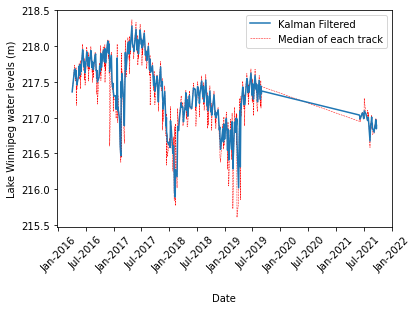

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(time_as_datetime, lake_water_levels, zorder=10, label="Kalman Filtered")
ax.plot(
    baseline_results["date_as_datetime"],
    baseline_results["lake_water_level"],
    'r--',
    linewidth=0.5,
    label="Median of each track"
)
ax.set_xlabel('Date', labelpad=20)
ax.set_ylabel('Lake Winnipeg water levels (m)')

# Set labels to be every six months
locator = matplotlib.dates.MonthLocator((1, 7))
fmt = matplotlib.dates.DateFormatter('%b-%Y')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(fmt)
for x in ax.get_xticklabels():
    x.set_rotation(45)

ax.legend()
plt.show()

##### Zoom in

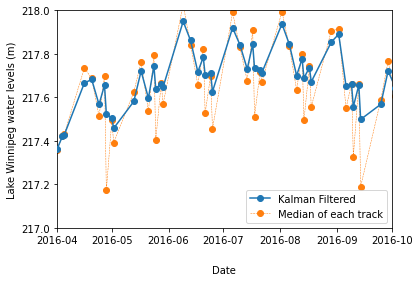

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(time_as_datetime, lake_water_levels, '-o', zorder=10, label="Kalman Filtered")
ax.plot(
    baseline_results["date_as_datetime"],
    baseline_results["lake_water_level"],
    '--o',
    linewidth=0.5,
    label="Median of each track"
)
ax.set_xlabel('Date', labelpad=20)
ax.set_ylabel('Lake Winnipeg water levels (m)')

ax.legend()
plt.xlim(datetime.datetime(month=4, day=1, year=2016), datetime.datetime(month=10, day=1, year=2016))
plt.ylim(217, 218)
plt.show()